In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings(action='ignore')

C:\Users\Datalab425\AppData\Local\Temp\ipykernel_35192\33567427.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# optimizer
from tensorflow.keras import optimizers
# define model
from tensorflow.keras.models import Sequential, Model
# layer function(elements)1
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# layer function(elements)2
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
# MSE loss function
from sklearn.metrics import mean_squared_error
# dateset split function
from sklearn.model_selection import train_test_split

%matplotlib inline
import tensorflow as tf
from numpy.random import seed
tf.random.set_seed(1)
seed(1)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [3]:
df = pd.read_csv('./dataset/ella/2023년 10월 엘니뇨 라니냐지수.csv')

df = df[['WTCH_YM','ENN_LNN_MNTH_AVG_VAL']]

df['WTCH_YM'] = pd.to_datetime(df['WTCH_YM'], format='%Y%m') # assume format YYYYMM
print(df.head())


     WTCH_YM  ENN_LNN_MNTH_AVG_VAL
0 1982-01-01             26.583536
1 1982-02-01             26.455164
2 1982-03-01             27.034367
3 1982-04-01             27.782887
4 1982-05-01             28.324877


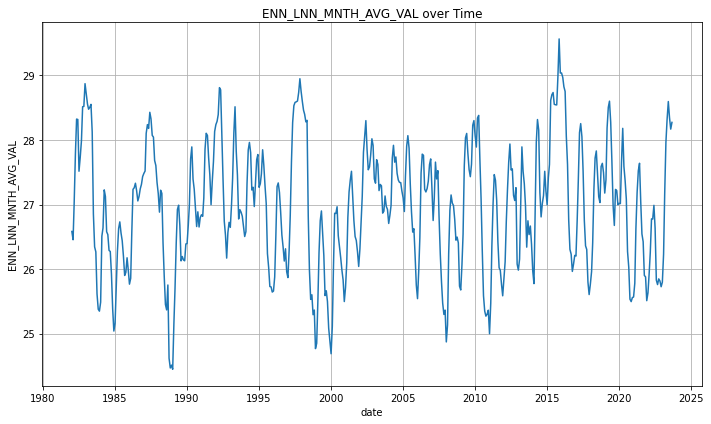

In [4]:
# drawing
plt.figure(figsize=(10, 6))
plt.plot(df.WTCH_YM, df.ENN_LNN_MNTH_AVG_VAL)
plt.xlabel('date')
plt.ylabel('ENN_LNN_MNTH_AVG_VAL')
plt.title('ENN_LNN_MNTH_AVG_VAL over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
train_df = df[df['WTCH_YM'] < '2020-01-01']
test_df = df[df['WTCH_YM'] >= '2020-01-01']

In [6]:
def make_series(data, window=1, dropnan=True):
    cols, names = [], []
    
    for i in range(window, 0, -1):
        cols.append(data.shift(i)) # shift: 행의 위치를 이동 [양수: 아래, 음수: 위]
        names += [f'{col_name}(t-{i})' for col_name in data.columns]
    
    cols.append(data)
    names += [f'{col}(t)' for col in data.columns]
    
    cols.append(data.shift(-1))
    names += [f'{col}(t+1)' for col in data.columns]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
window = 11
series = make_series(train_df.drop('WTCH_YM', axis=1), window=window)
print(series.head())

labels_col = 'ENN_LNN_MNTH_AVG_VAL(t+1)' # label is t+1 
labels = series[labels_col]
series.drop(labels_col, axis=1, inplace=True)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print(X_train.head())

    ENN_LNN_MNTH_AVG_VAL(t-11)  ENN_LNN_MNTH_AVG_VAL(t-10)  ENN_LNN_MNTH_AVG_VAL(t-9)  ENN_LNN_MNTH_AVG_VAL(t-8)  ENN_LNN_MNTH_AVG_VAL(t-7)  ENN_LNN_MNTH_AVG_VAL(t-6)  ENN_LNN_MNTH_AVG_VAL(t-5)  ENN_LNN_MNTH_AVG_VAL(t-4)  ENN_LNN_MNTH_AVG_VAL(t-3)  ENN_LNN_MNTH_AVG_VAL(t-2)  ENN_LNN_MNTH_AVG_VAL(t-1)  ENN_LNN_MNTH_AVG_VAL(t)  ENN_LNN_MNTH_AVG_VAL(t+1)
11                   26.583536                   26.455164                  27.034367                  27.782887                  28.324877                  28.318243                  27.516779                  27.732350                  27.988077                  28.516157                  28.520609                28.873512                  28.718626
12                   26.455164                   27.034367                  27.782887                  28.324877                  28.318243                  27.516779                  27.732350                  27.988077                  28.516157                  28.520609                  

In [8]:
# given y_true, y_pred list, calculate r2, corr, mape, rmse than return result with df
def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    
    df = pd.DataFrame({
        'R2': r2,
        "Corr": corr,
        "RMSE": rmse,
        "MAPE": mape
    }, index=[0]) # 1행 데이터이므로 index를 0 하나만 부여
    return df

In [34]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
def MinMax(y_true, y_pred, m='min'):
    if m == 'min':
        return min(min(y_true), min(y_pred)) - 2
    else:
        return max(max(y_true), max(y_pred)) + 2
    
# x = date, y = MeanTemp
def myGraph(temp, title):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [2.5, 1]})
    axs[0].plot(temp['WTCH_YM'], temp['y_true'], label = 'Original')
    axs[0].plot(temp['WTCH_YM'], temp['y_pred'], label = 'Predicted')
    axs[0].legend(loc='upper right')
    axs[0].title.set_text(title)
    axs[0].set_xlabel('WTCH_YM')
    axs[0].set_ylabel('ENN_LNN_MNTH_AVG_VAL')
    
    axs[1].plot(temp.y_true, temp.y_pred, '.')
    plt.xlim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, 'max'))
    plt.ylim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, 'max'))
    abline(1,0)
    plt.title(title)
    plt.xlabel('Original')
    plt.ylabel('Predicted')
    

# MLP

In [12]:
# MLP
epochs = 500
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

#MLP: input(12) - 100 - 1
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               1300      
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


In [15]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/500
9/9 - 2s - loss: 82.1275 - val_loss: 25.6446 - 2s/epoch - 232ms/step
Epoch 2/500
9/9 - 0s - loss: 10.5289 - val_loss: 1.7367 - 44ms/epoch - 5ms/step
Epoch 3/500
9/9 - 0s - loss: 3.5897 - val_loss: 6.4826 - 41ms/epoch - 5ms/step
Epoch 4/500
9/9 - 0s - loss: 5.2963 - val_loss: 3.5921 - 42ms/epoch - 5ms/step
Epoch 5/500
9/9 - 0s - loss: 2.2350 - val_loss: 1.7100 - 44ms/epoch - 5ms/step
Epoch 6/500
9/9 - 0s - loss: 1.7605 - val_loss: 1.9770 - 39ms/epoch - 4ms/step
Epoch 7/500
9/9 - 0s - loss: 1.7972 - val_loss: 1.7211 - 46ms/epoch - 5ms/step
Epoch 8/500
9/9 - 0s - loss: 1.5769 - val_loss: 1.7666 - 41ms/epoch - 5ms/step
Epoch 9/500
9/9 - 0s - loss: 1.6285 - val_loss: 1.7678 - 38ms/epoch - 4ms/step
Epoch 10/500
9/9 - 0s - loss: 1.5613 - val_loss: 1.6958 - 36ms/epoch - 4ms/step
Epoch 11/500
9/9 - 0s - loss: 1.5740 - val_loss: 1.6976 - 43ms/epoch - 5ms/step
Epoch 12/500
9/9 - 0s - loss: 1.5648 - val_loss: 1.6970 - 43ms/epoch - 5ms/step
Epoch 13/500
9/9 - 0s - loss: 1.5649 - val_los

Epoch 104/500
9/9 - 0s - loss: 1.1692 - val_loss: 1.2927 - 49ms/epoch - 5ms/step
Epoch 105/500
9/9 - 0s - loss: 1.1589 - val_loss: 1.2809 - 43ms/epoch - 5ms/step
Epoch 106/500
9/9 - 0s - loss: 1.1532 - val_loss: 1.2998 - 50ms/epoch - 6ms/step
Epoch 107/500
9/9 - 0s - loss: 1.1746 - val_loss: 1.2736 - 49ms/epoch - 5ms/step
Epoch 108/500
9/9 - 0s - loss: 1.1584 - val_loss: 1.2660 - 38ms/epoch - 4ms/step
Epoch 109/500
9/9 - 0s - loss: 1.1532 - val_loss: 1.2598 - 37ms/epoch - 4ms/step
Epoch 110/500
9/9 - 0s - loss: 1.1483 - val_loss: 1.2532 - 41ms/epoch - 5ms/step
Epoch 111/500
9/9 - 0s - loss: 1.1251 - val_loss: 1.2536 - 39ms/epoch - 4ms/step
Epoch 112/500
9/9 - 0s - loss: 1.1190 - val_loss: 1.2566 - 40ms/epoch - 4ms/step
Epoch 113/500
9/9 - 0s - loss: 1.1198 - val_loss: 1.2395 - 39ms/epoch - 4ms/step
Epoch 114/500
9/9 - 0s - loss: 1.1090 - val_loss: 1.2454 - 37ms/epoch - 4ms/step
Epoch 115/500
9/9 - 0s - loss: 1.1148 - val_loss: 1.2311 - 37ms/epoch - 4ms/step
Epoch 116/500
9/9 - 0s - los

9/9 - 0s - loss: 0.7074 - val_loss: 0.7979 - 48ms/epoch - 5ms/step
Epoch 206/500
9/9 - 0s - loss: 0.6853 - val_loss: 0.8078 - 48ms/epoch - 5ms/step
Epoch 207/500
9/9 - 0s - loss: 0.6867 - val_loss: 0.7924 - 39ms/epoch - 4ms/step
Epoch 208/500
9/9 - 0s - loss: 0.7006 - val_loss: 0.7894 - 39ms/epoch - 4ms/step
Epoch 209/500
9/9 - 0s - loss: 0.6793 - val_loss: 0.7824 - 40ms/epoch - 4ms/step
Epoch 210/500
9/9 - 0s - loss: 0.6822 - val_loss: 0.7795 - 39ms/epoch - 4ms/step
Epoch 211/500
9/9 - 0s - loss: 0.6696 - val_loss: 0.7757 - 39ms/epoch - 4ms/step
Epoch 212/500
9/9 - 0s - loss: 0.6680 - val_loss: 0.7715 - 37ms/epoch - 4ms/step
Epoch 213/500
9/9 - 0s - loss: 0.6704 - val_loss: 0.7885 - 36ms/epoch - 4ms/step
Epoch 214/500
9/9 - 0s - loss: 0.6586 - val_loss: 0.7651 - 36ms/epoch - 4ms/step
Epoch 215/500
9/9 - 0s - loss: 0.6576 - val_loss: 0.7650 - 36ms/epoch - 4ms/step
Epoch 216/500
9/9 - 0s - loss: 0.6575 - val_loss: 0.7693 - 46ms/epoch - 5ms/step
Epoch 217/500
9/9 - 0s - loss: 0.6592 - va

Epoch 307/500
9/9 - 0s - loss: 0.4700 - val_loss: 0.5190 - 40ms/epoch - 4ms/step
Epoch 308/500
9/9 - 0s - loss: 0.4495 - val_loss: 0.5095 - 37ms/epoch - 4ms/step
Epoch 309/500
9/9 - 0s - loss: 0.4326 - val_loss: 0.5172 - 41ms/epoch - 5ms/step
Epoch 310/500
9/9 - 0s - loss: 0.4322 - val_loss: 0.5051 - 55ms/epoch - 6ms/step
Epoch 311/500
9/9 - 0s - loss: 0.4210 - val_loss: 0.5069 - 52ms/epoch - 6ms/step
Epoch 312/500
9/9 - 0s - loss: 0.4313 - val_loss: 0.5806 - 86ms/epoch - 10ms/step
Epoch 313/500
9/9 - 0s - loss: 0.4705 - val_loss: 0.5012 - 54ms/epoch - 6ms/step
Epoch 314/500
9/9 - 0s - loss: 0.4316 - val_loss: 0.4951 - 69ms/epoch - 8ms/step
Epoch 315/500
9/9 - 0s - loss: 0.4453 - val_loss: 0.5098 - 45ms/epoch - 5ms/step
Epoch 316/500
9/9 - 0s - loss: 0.4164 - val_loss: 0.5048 - 38ms/epoch - 4ms/step
Epoch 317/500
9/9 - 0s - loss: 0.4243 - val_loss: 0.4883 - 41ms/epoch - 5ms/step
Epoch 318/500
9/9 - 0s - loss: 0.4139 - val_loss: 0.4866 - 38ms/epoch - 4ms/step
Epoch 319/500
9/9 - 0s - lo

Epoch 409/500
9/9 - 0s - loss: 0.3219 - val_loss: 0.3681 - 40ms/epoch - 4ms/step
Epoch 410/500
9/9 - 0s - loss: 0.3155 - val_loss: 0.4323 - 41ms/epoch - 5ms/step
Epoch 411/500
9/9 - 0s - loss: 0.3508 - val_loss: 0.4181 - 41ms/epoch - 5ms/step
Epoch 412/500
9/9 - 0s - loss: 0.3733 - val_loss: 0.3699 - 43ms/epoch - 5ms/step
Epoch 413/500
9/9 - 0s - loss: 0.4057 - val_loss: 0.3848 - 43ms/epoch - 5ms/step
Epoch 414/500
9/9 - 0s - loss: 0.3293 - val_loss: 0.3782 - 39ms/epoch - 4ms/step
Epoch 415/500
9/9 - 0s - loss: 0.3322 - val_loss: 0.3652 - 44ms/epoch - 5ms/step
Epoch 416/500
9/9 - 0s - loss: 0.3379 - val_loss: 0.4138 - 39ms/epoch - 4ms/step
Epoch 417/500
9/9 - 0s - loss: 0.3253 - val_loss: 0.3592 - 42ms/epoch - 5ms/step
Epoch 418/500
9/9 - 0s - loss: 0.3109 - val_loss: 0.4034 - 51ms/epoch - 6ms/step
Epoch 419/500
9/9 - 0s - loss: 0.3241 - val_loss: 0.3643 - 46ms/epoch - 5ms/step
Epoch 420/500
9/9 - 0s - loss: 0.3227 - val_loss: 0.3572 - 46ms/epoch - 5ms/step
Epoch 421/500
9/9 - 0s - los

In [28]:
# prediction
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)

#column to row
Y_train_ = pd.DataFrame({'y_true': Y_train, 'y_pred': mlp_train_pred.reshape(mlp_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
#merge by using index
Y_train_ = pd.merge(Y_train_, train_df, left_index=True, right_index=True, how='left')

Y_valid_ = pd.DataFrame({'y_true': Y_valid, 'y_pred': mlp_valid_pred.reshape(mlp_valid_pred.shape[0],)}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_df, left_index=True, right_index=True, how='left')

In [31]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,MAPE
0,50.164,0.849,0.7,2.122


In [32]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,MAPE
0,35.525,0.813,0.756,2.316


Obs of Valid Set:  178


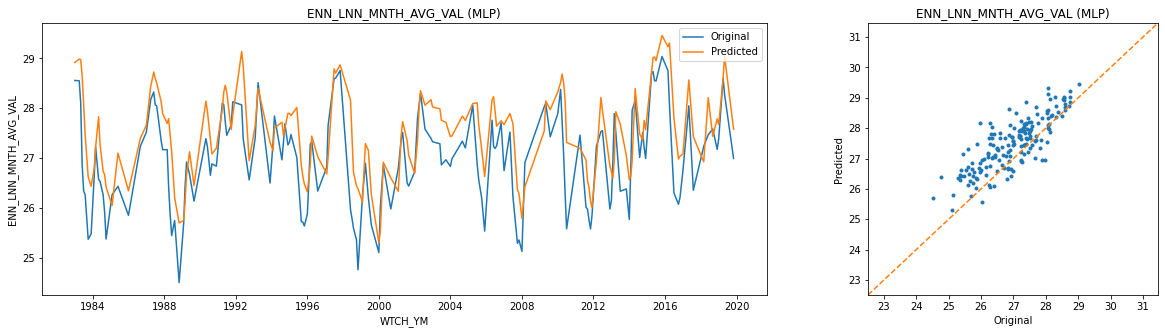

In [35]:
print('Obs of Valid Set: ', Y_valid_.shape[0])
myGraph(Y_valid_, 'ENN_LNN_MNTH_AVG_VAL (MLP)')